### Evaluation notebook for trained and saved models

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=''
import numpy as np
import torch
from torch import nn
from mapsgan import cLRSolver, cVAESolver , BicycleGenerator, ToyGenerator, ToyDiscriminator, data_loader
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from pathlib import Path
import os, glob

env: CUDA_VISIBLE_DEVICES=''


In [2]:
torch.cuda.is_available()

False

### Set these manually according to the script

In [3]:
# can directly copy-paste from the script
mode = 'clr'
fileprefix = '/local/clr_1'
lr_gen = 1e-3
lr_dis = 1e-3

In [4]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
filesearch = root_path + '/models' + fileprefix + '*10000*' # can change here acc to saved epoch
filelist = glob.glob(filesearch)
filename = filelist[0]

In [5]:
filename

'/home/yy/ADL4CV/mapsgan/models/local/clr_1_20190114-160949_epoch_10000'

### Initializing dataloader, models, solver

In [16]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.train_dir,
                                  shuffle=True)
_ , testloader = data_loader(in_len=8, out_len=12, batch_size=1, num_workers=1, path=experiment.test_dir,
                                  shuffle=False)

In [7]:
generator = BicycleGenerator(generator=ToyGenerator, start_mode=mode)
discriminator = ToyDiscriminator()

In [8]:
if mode == 'clr':
    solver = cLRSolver(generator, discriminator, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})
elif mode == 'cvae':
    solver = cVAESolver(generator, discriminator, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})

### Looking at losses

In [10]:
epochs = solver.load_checkpoint(filename)

AttributeError: 'NoneType' object has no attribute 'load_state_dict'

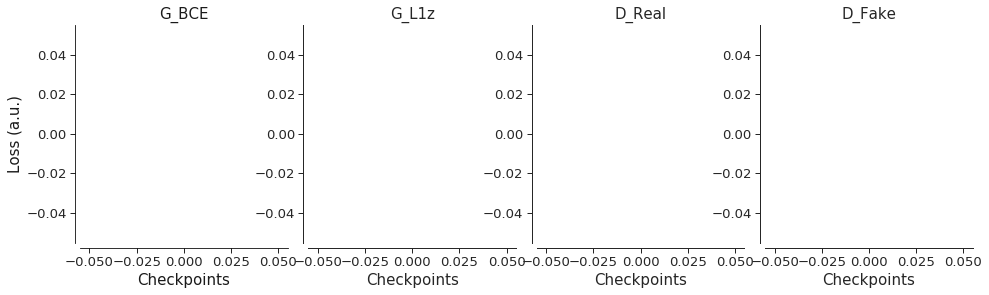

In [11]:
vis = Visualization()
vis.loss(solver.train_loss_history)

### Looking at predictions

In [12]:
output = solver.test(testloader, load_checkpoint_from=filename) #can also use trainloader for overfit

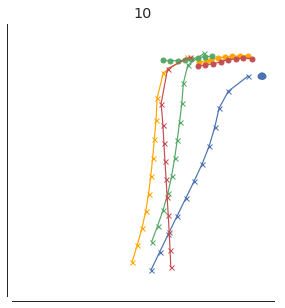

In [13]:
vis = Visualization()
ll = vis.trajectories(output, scenes=[10])

### Interpolation

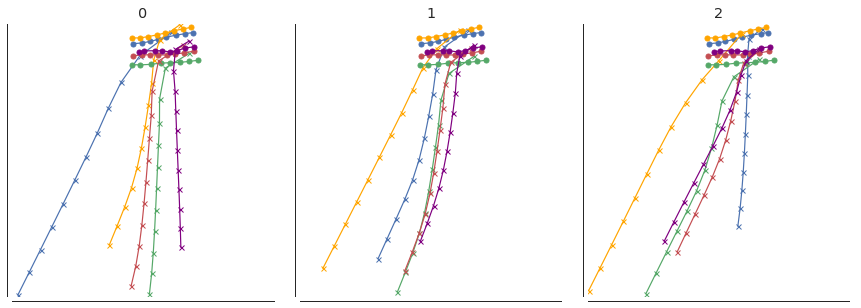

In [47]:
for s in [44]:#[3,25,30,44,65]:
    out = solver.interpolate(testloader, scene=s, seed=10, stepsize=0.8)
    vis.trajectories(out, scenes = None)
    plt.show()

In [73]:
s=44
sss = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
csm = np.zeros_like(sss)
for i, ss in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    out = solver.interpolate(testloader, scene=s, seed=10, stepsize=ss)
    num_coord = out['xy_pred'][0].shape[2]
    num_steps = out['xy_pred'][0].shape[0]
    num_agents = out['xy_pred'][0].shape[1]
    num_z = len(out['xy_pred'])
    new_list = [None]*num_agents
    agent_array = np.zeros([num_steps, num_z, num_coord])
    for agent in range(num_agents):
        for z in range(num_z):
            agent_array[:,z,:] = out['xy_pred'][z][:,agent,:]
        new_list[agent] = agent_array  
    cosine_score_model = cos_scene(new_list)
    csm[i] = cosine_score_model/num_z/num_agents

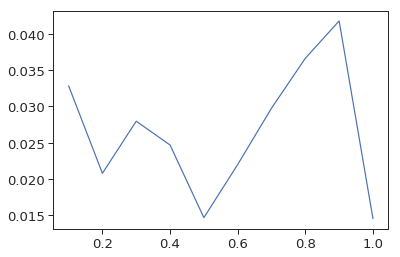

In [74]:
plt.plot(sss, csm)

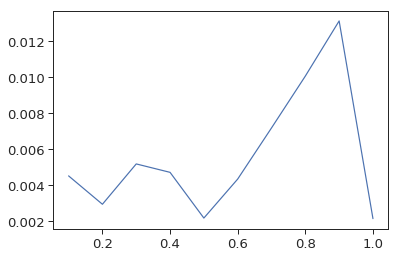

In [70]:
plt.plot(sss,csm)